In [104]:
import os
import librosa
from librosa.feature import melspectrogram
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from PIL import Image
from tqdm import tqdm
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns

import audiomentations
from audiomentations import AddGaussianNoise

import torch
import torchvision
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from torchvision.transforms import v2
from torch import nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR

# Data Preparation

## Define hyperparameters and paths

In [2]:
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512

In [53]:
AUDIO_DIR = 'audio/'
SPECTROGRAM_DIR = 'spectrogram_224/'
ANNOTATIONS_FILE = 'annotations.csv'
NUM_CLASSES = 8

In [73]:
BATCH_SIZE = 8
LEARNING_RATE = 0.01
EPOCHS = 20

## Utilities

In [5]:
def get_melsp(y, sr, resize):
    """
    Generates a Mel-spectrogram image from an audio signal and normalizes it.
    
    Args:
        y (np.ndarray): Audio time-series data.
        sr (int): Sampling rate of the audio.
        resize (int): Size to resize the spectrogram image.
    
    Returns:
        PIL.Image.Image: Image object of the Mel-spectrogram normalized and resized.
    """
    # Compute the Mel-spectrogram
    mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, 
                                               n_mels=N_MELS, 
                                               n_fft=N_FFT,
                                               hop_length=HOP_LENGTH)
    mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
    
    # Normalize the spectrogram
    mel_spect_db = (mel_spect_db - mel_spect_db.min()) / (mel_spect_db.max() - mel_spect_db.min())
    
    # Convert to image and resize
    return Image.fromarray(mel_spect_db * 255).convert('L').resize((resize, resize), Image.LANCZOS)

In [6]:
def map_arousal_valence_to_emotion(arousal, valence):
    """
    Maps arousal and valence values to discrete emotion classes.
    
    Args:
        arousal (float): Arousal value scaled from 1 to 9.
        valence (float): Valence value scaled from 1 to 9.
    
    Returns:
        int: Integer label corresponding to an emotion class.
            - 0: Excited
            - 1: Happy
            - 2: Content
            - 3: Calm
            - 4: Depressed
            - 5: Tired
            - 6: Tense
            - 7: Frustrated
            - -1: Undefined (if values do not fall into any defined range)
    """
    if 5 <= valence <= 9:
        if 7 <= arousal <= 9:
            return 0  # Excited
        elif 5 <= arousal < 7:
            return 1  # Happy
        elif 3 <= arousal < 5:
            return 2  # Content
        elif 1 <= arousal < 3:
            return 3  # Calm
    elif 1 <= valence <= 5:
        if 7 <= arousal <= 9:
            return 6  # Tense
        elif 5 <= arousal < 7:
            return 7  # Frustrated
        elif 3 <= arousal < 5:
            return 4  # Depressed
        elif 1 <= arousal < 3:
            return 5  # Tired
    
    return -1  # Undefined


In [7]:
def grayscale_to_rgb(image):
    """
    Converts a grayscale image to RGB by duplicating the grayscale channel across all three RGB channels.
    
    Args:
        image (PIL.Image.Image): Grayscale image to convert.
    
    Returns:
        PIL.Image.Image: RGB image with the same data in all three channels.
    """
    return Image.merge("RGB", (image, image, image))

In [72]:
def display_result():
    epochs = range(1, EPOCHS + 1)

    plt.figure(figsize=(14, 7))
    
    print(f'Batch Size: {BATCH_SIZE}\nEpochs: {EPOCHS}\nLearning Rate: {LEARNING_RATE}\nLoss Function: {criterion}\nOptimizer: {optimizer}\n')
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, test_losses, 'r', label='Test Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Training and Testing Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
    plt.plot(epochs, test_accuracies, 'r', label='Test Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()
    print(f'Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.2f}%')
    print(f'Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%')

## Get data

In [8]:
# Convert audio to mel-spectrogram and save in SPECTROGRAM_DIR
if not os.path.exists(SPECTROGRAM_DIR):
    os.makedirs(SPECTROGRAM_DIR)
    print(f'Created directory: {SPECTROGRAM_DIR}')
    
    print('Processing audio files..')
    for filename in os.listdir(AUDIO_DIR):
        if filename.endswith('.mp3'):
            audio_path = os.path.join(AUDIO_DIR, filename)
            spectrogram_filename = f'{os.path.splitext(filename)[0]}.png'
            spectrogram_path = os.path.join(SPECTROGRAM_DIR, spectrogram_filename)

            y, sr = librosa.load(audio_path, sr=None)
            output_path = os.path.join(SPECTROGRAM_DIR, spectrogram_filename)
            get_melsp(y, sr, 224).save(output_path)
            
    print('Finished processing audio files.')
else:
    print('Directory already exists.')

Directory already exists.


## Create dataset

In [9]:
class SpectrogramDataset(Dataset):
    EMOTION_MAP = {
        0: 'Excited',
        1: 'Happy',
        2: 'Content',
        3: 'Calm',
        4: 'Sad',
        5: 'Melancholic',
        6: 'Angry',
        7: 'Stressed'
    }
    def __init__(self, spectrogram_dir, annotations, transform=None):
        """
        Initializes the SpectrogramDataset.
        
        Args:
            spectrogram_dir (str): Directory containing the spectrogram images.
            annotations (pd.DataFrame): DataFrame containing song_id, valence_mean, and arousal_mean.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.spectrogram_dir = spectrogram_dir
        self.annotations = annotations
        self.labels = annotations[[' valence_mean', ' arousal_mean']].to_numpy().astype(np.float32)
        self.transform = transform

        # Calculate emotion labels and append as a new column
        self.annotations['emotion_label'] = self.annotations.apply(
            lambda row: self.EMOTION_MAP[map_arousal_valence_to_emotion(row[' arousal_mean'], row[' valence_mean'])],
            axis=1
        )


    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.annotations)

    def __getitem__(self, idx):
        """
        Generates one sample of data.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            Tuple: (image, emotion_label)
        """
        song_id = int(self.annotations.iloc[idx]['song_id'])
        img_path = os.path.join(self.spectrogram_dir, f'{song_id}.png')

        # Load image
        image = Image.open(img_path).convert('L')
        image = grayscale_to_rgb(image)

        if self.transform:
            image = self.transform(image)

        arousal = self.labels[idx][1]
        valence = self.labels[idx][0]
        emotion_label = map_arousal_valence_to_emotion(arousal, valence)

        return image, emotion_label

In [10]:
def random_segment(image):
    """Randomly selects a segment of the input image along the width dimension."""
    w, h = image.size
    segment_size = np.random.randint(w // 2, w)
    segment_start = np.random.randint(0, w - segment_size)
    return image.crop((segment_start, 0, segment_start + segment_size, h))

def random_shift(image):
    """Randomly shifts the input image horizontally and vertically."""
    w, h = image.size
    shift_x, shift_y = np.random.randint(-20, 20, size=2)
    return image.transform((w, h), Image.AFFINE, (1, 0, shift_x, 0, 1, shift_y))

def add_gaussian_noise(image):
    """Adds Gaussian noise to the input image."""
    mean = 0
    var = 0.01
    sigma = var ** 0.5
    noisy_image = np.array(image)
    noise = np.random.normal(mean, sigma, noisy_image.shape).astype(np.uint8)
    noisy_image = np.clip((noisy_image + noise * 255), 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_image)

def random_zoom(image):
    """Randomly zooms in or out of the input image."""
    zoom_factor = np.random.uniform(0.8, 1.2)
    w, h = image.size
    new_w, new_h = int(w * zoom_factor), int(h * zoom_factor)
    return image.resize((new_w, new_h), Image.LANCZOS).crop((0, 0, w, h))


In [11]:
# transform = transforms.Compose([
#     transforms.Lambda(lambda x: random_segment(x)),
#     transforms.Lambda(lambda x: random_shift(x)),
#     transforms.Lambda(lambda x: add_gaussian_noise(x)),
#     transforms.Lambda(lambda x: random_zoom(x)),
#     transforms.ToTensor()                      
# ])

In [14]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

inception_transform = v2.Compose([
    v2.Resize((299, 299)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
annotations = pd.read_csv(ANNOTATIONS_FILE)
dataset = SpectrogramDataset(SPECTROGRAM_DIR, annotations, transform=transform)
inception_dataset = SpectrogramDataset(SPECTROGRAM_DIR, annotations, transform=inception_transform)

In [55]:
# Split the dataset into train and test set

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
incep_train_dataset, incep_test_dataset = random_split(inception_dataset, [train_size, test_size])
print(f'Size of train dataset: {train_size}\nSize of test dataset: {test_size}')

Size of train dataset: 1395
Size of test dataset: 349


In [56]:
# Load test and train sets to DataLoaders

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
incep_train_dataloader = DataLoader(incep_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
incep_test_dataloader = DataLoader(incep_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [57]:
batch_images, batch_labels = next(iter(train_dataloader))
batch_images.shape

torch.Size([8, 3, 224, 224])

In [21]:
image, label = train_dataset[0]

In [22]:
dataset.annotations.emotion_label.unique()

array(['Sad', 'Happy', 'Stressed', 'Content', 'Calm', 'Melancholic',
       'Excited', 'Angry'], dtype=object)

In [23]:
dataset.annotations

,song_id,valence_mean,valence_std,arousal_mean,arousal_std,emotion_label
0,2,3.1,0.94,3.0,0.63,Sad
1,3,3.5,1.75,3.3,1.62,Sad
2,4,5.7,1.42,5.5,1.63,Happy
3,5,4.4,2.01,5.3,1.85,Stressed
4,7,5.8,1.47,6.4,1.69,Happy
...,...,...,...,...,...,...
1739,1996,3.9,1.87,5.9,2.21,Stressed
1740,1997,5.3,1.42,3.9,1.14,Content
1741,1998,6.4,1.50,6.2,1.60,Happy
1742,1999,4.6,2.11,5.4,1.80,Stressed


# Data Visualization

In [24]:
def plot_valence_arousal_distribution(df):
    plt.figure(figsize=(9, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[' valence_mean'], kde=True, bins=30)
    plt.title('Distribution of Valence Mean')
    plt.xlabel('Valence Mean')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    sns.histplot(df[' arousal_mean'], kde=True, bins=30)
    plt.title('Distribution of Arousal Mean')
    plt.xlabel('Arousal Mean')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def scatter_valence_arousal(df):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=' valence_mean', y=' arousal_mean', hue='emotion_label', data=df, palette='tab10')
    plt.title('Scatter Plot of Valence vs Arousal')
    plt.xlabel('Valence Mean')
    plt.ylabel('Arousal Mean')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.show()

def barplot_emotion_counts(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='emotion_label', hue='emotion_label', data=df, palette='tab10', order=df['emotion_label'].value_counts().index, legend=False)
    plt.title('Counts of Each Emotion Label')
    plt.xlabel('Emotion Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

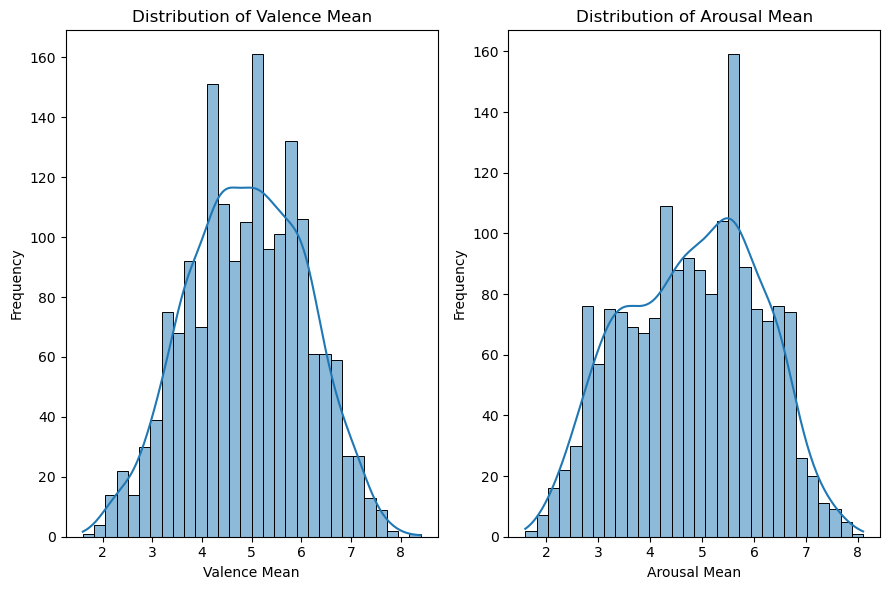

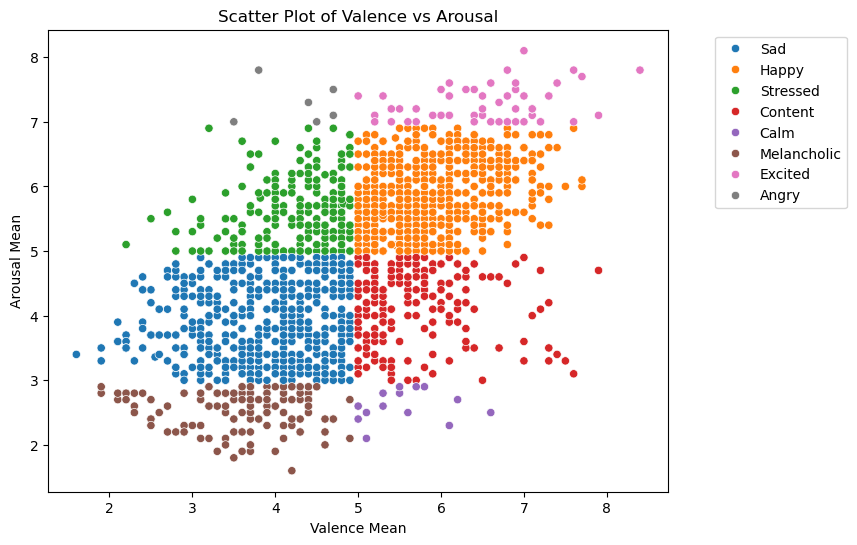

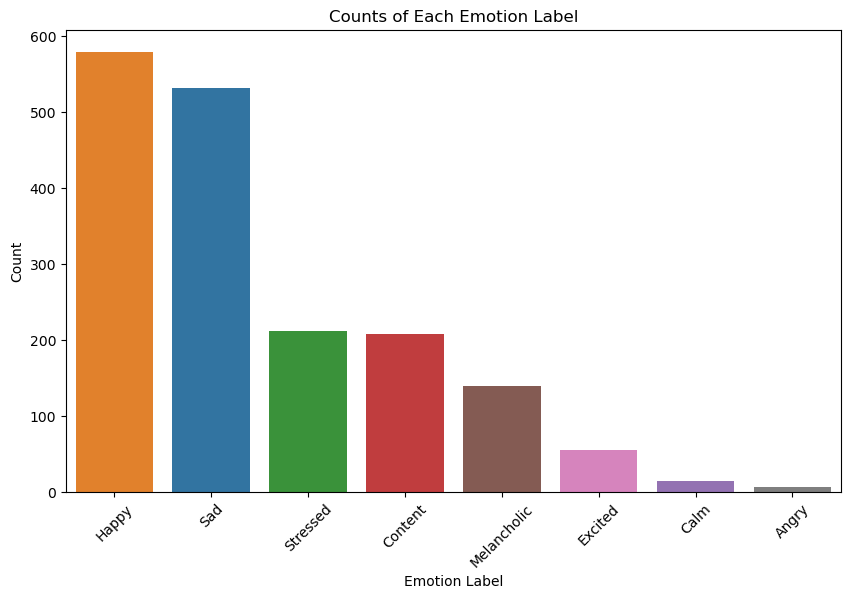

In [25]:
# Plot visualizations
plot_valence_arousal_distribution(annotations)
scatter_valence_arousal(annotations)
barplot_emotion_counts(annotations)

# Define Models

In [45]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # self.resnet = models.resnet50(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.resnet(x)

In [27]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        num_features = self.vgg.classifier[6].in_features
        self.vgg.classifier[6] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.vgg16(x)

In [28]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.densenet(x)

In [29]:
class InceptionV3(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.inception = models.inception_v3(pretrained=True)
        num_features = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_features, num_classes)
        
        if self.inception.AuxLogits is not None:
            num_aux_features = self.inception.AuxLogits.fc.in_features
            self.inception.AuxLogits.fc = nn.Linear(num_aux_features, num_classes)

    def forward(self, x):
        if self.training and self.inception.aux_logits:
            aux_out, x = self.inception(x)
            return aux_out, x
        else:
            x = self.inception(x)
            return x

# Train and Test Models

In [30]:
criterion = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [103]:
EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 8
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Training

### Resnet50

In [108]:
resnet50_model = ResNet50(NUM_CLASSES)
optimizer = optim.Adam(resnet50_model.parameters(), lr=LEARNING_RATE)
resnet50_model.to(device)
CosineAnnealingLR(optimizer, T_max=10)

In [109]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    resnet50_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar_train = tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{EPOCHS}', unit='batch')
    
    for images, labels in pbar_train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet50_model(images)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)

        del loss, outputs
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar_train.set_postfix({'Loss': running_loss / (total if total > 0 else 1), 'Accuracy': 100. * correct / total})
    
    # Calculate average training loss and accuracy for the epoch
    epoch_train_loss = running_loss / len(train_dataloader)
    epoch_train_accuracy = 100. * correct / total
    
    # Append to lists
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)
    
    # Print epoch summary after completing training phase
    print(f'Epoch {epoch+1}, Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_accuracy:.2f}%')

    torch.cuda.empty_cache()

    scheduler.step()

    # Testing phase
    resnet50_model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    # Initialize tqdm for progress bar
    pbar_test = tqdm(test_dataloader, desc=f'Testing Epoch {epoch+1}/{EPOCHS}', unit='batch', leave=False)

    # Disable gradients for evaluation
    with torch.no_grad():
        for images, labels in pbar_test:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet50_model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar_test.set_postfix({'Loss': test_loss / (total if total > 0 else 1), 'Accuracy': 100. * correct / total})

    # Calculate average test loss and accuracy for the epoch
    epoch_test_loss = test_loss / len(test_dataloader)
    epoch_test_accuracy = 100. * correct / total

    # Append to lists
    test_losses.append(epoch_test_loss)
    test_accuracies.append(epoch_test_accuracy)

    # Print epoch summary after completing testing phase
    print(f'Epoch {epoch+1}, Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_accuracy:.2f}%')

Training Epoch 1/20: 100%|█████████████████████████████| 175/175 [00:15<00:00, 11.40batch/s, Loss=0.229, Accuracy=45.5]


Epoch 1, Training Loss: 1.8287, Training Accuracy: 45.52%


Epoch 1, Test Loss: 1.7879, Test Accuracy: 49.57%


Training Epoch 2/20: 100%|█████████████████████████████| 175/175 [00:14<00:00, 11.94batch/s, Loss=0.228, Accuracy=46.1]


Epoch 2, Training Loss: 1.8162, Training Accuracy: 46.09%


Epoch 2, Test Loss: 1.9048, Test Accuracy: 36.68%


Training Epoch 3/20: 100%|█████████████████████████████| 175/175 [00:14<00:00, 11.74batch/s, Loss=0.228, Accuracy=46.5]


Epoch 3, Training Loss: 1.8162, Training Accuracy: 46.45%


Epoch 3, Test Loss: 1.7779, Test Accuracy: 49.86%


Training Epoch 4/20: 100%|█████████████████████████████| 175/175 [00:15<00:00, 11.38batch/s, Loss=0.227, Accuracy=46.6]


Epoch 4, Training Loss: 1.8099, Training Accuracy: 46.59%


Epoch 4, Test Loss: 1.7801, Test Accuracy: 48.42%


Training Epoch 5/20: 100%|█████████████████████████████| 175/175 [00:15<00:00, 11.30batch/s, Loss=0.233, Accuracy=41.6]


Epoch 5, Training Loss: 1.8545, Training Accuracy: 41.65%


Epoch 5, Test Loss: 1.9105, Test Accuracy: 36.68%


Training Epoch 6/20: 100%|█████████████████████████████| 175/175 [00:15<00:00, 11.17batch/s, Loss=0.225, Accuracy=48.5]


Epoch 6, Training Loss: 1.7917, Training Accuracy: 48.53%


Epoch 6, Test Loss: 1.7551, Test Accuracy: 51.86%


Training Epoch 7/20: 100%|█████████████████████████████| 175/175 [00:15<00:00, 11.29batch/s, Loss=0.222, Accuracy=49.6]


Epoch 7, Training Loss: 1.7716, Training Accuracy: 49.61%


Epoch 7, Test Loss: 1.7471, Test Accuracy: 53.01%


Training Epoch 8/20: 100%|███████████████████████████████| 175/175 [00:15<00:00, 11.26batch/s, Loss=0.225, Accuracy=48]


Epoch 8, Training Loss: 1.7897, Training Accuracy: 48.03%


Epoch 8, Test Loss: 1.7453, Test Accuracy: 53.30%


Training Epoch 9/20: 100%|█████████████████████████████| 175/175 [00:16<00:00, 10.82batch/s, Loss=0.221, Accuracy=50.8]


Epoch 9, Training Loss: 1.7646, Training Accuracy: 50.82%


Epoch 9, Test Loss: 1.7608, Test Accuracy: 50.14%


Training Epoch 10/20: 100%|█████████████████████████████| 175/175 [00:15<00:00, 10.97batch/s, Loss=0.22, Accuracy=51.3]


Epoch 10, Training Loss: 1.7572, Training Accuracy: 51.25%


Epoch 10, Test Loss: 1.7556, Test Accuracy: 51.58%


Training Epoch 11/20: 100%|████████████████████████████| 175/175 [00:15<00:00, 11.00batch/s, Loss=0.221, Accuracy=51.3]


Epoch 11, Training Loss: 1.7585, Training Accuracy: 51.25%


Epoch 11, Test Loss: 1.7419, Test Accuracy: 52.15%


Training Epoch 12/20: 100%|████████████████████████████| 175/175 [00:16<00:00, 10.88batch/s, Loss=0.221, Accuracy=51.3]


Epoch 12, Training Loss: 1.7580, Training Accuracy: 51.33%


Epoch 12, Test Loss: 1.7619, Test Accuracy: 51.00%


Training Epoch 13/20: 100%|████████████████████████████| 175/175 [00:15<00:00, 11.14batch/s, Loss=0.221, Accuracy=51.4]


Epoch 13, Training Loss: 1.7609, Training Accuracy: 51.40%


Epoch 13, Test Loss: 1.7531, Test Accuracy: 52.15%


Training Epoch 14/20: 100%|████████████████████████████| 175/175 [00:15<00:00, 11.01batch/s, Loss=0.218, Accuracy=53.4]


Epoch 14, Training Loss: 1.7366, Training Accuracy: 53.41%


Epoch 14, Test Loss: 1.7733, Test Accuracy: 49.28%


Training Epoch 15/20: 100%|█████████████████████████████| 175/175 [00:16<00:00, 10.82batch/s, Loss=0.22, Accuracy=51.8]


Epoch 15, Training Loss: 1.7547, Training Accuracy: 51.76%


Epoch 15, Test Loss: 1.7476, Test Accuracy: 53.01%


Training Epoch 16/20: 100%|█████████████████████████████| 175/175 [00:16<00:00, 10.91batch/s, Loss=0.22, Accuracy=51.6]


Epoch 16, Training Loss: 1.7566, Training Accuracy: 51.61%


Epoch 16, Test Loss: 1.7663, Test Accuracy: 50.72%


Training Epoch 17/20: 100%|█████████████████████████████| 175/175 [00:15<00:00, 10.98batch/s, Loss=0.22, Accuracy=51.7]


Epoch 17, Training Loss: 1.7530, Training Accuracy: 51.68%


Epoch 17, Test Loss: 1.7345, Test Accuracy: 53.87%


Training Epoch 18/20: 100%|████████████████████████████| 175/175 [00:16<00:00, 10.88batch/s, Loss=0.219, Accuracy=52.9]


Epoch 18, Training Loss: 1.7472, Training Accuracy: 52.90%


Epoch 18, Test Loss: 1.7285, Test Accuracy: 54.44%


Training Epoch 19/20: 100%|████████████████████████████| 175/175 [00:15<00:00, 10.97batch/s, Loss=0.219, Accuracy=52.5]


Epoch 19, Training Loss: 1.7493, Training Accuracy: 52.54%


Epoch 19, Test Loss: 1.7391, Test Accuracy: 53.01%


Training Epoch 20/20: 100%|████████████████████████████| 175/175 [00:15<00:00, 11.13batch/s, Loss=0.222, Accuracy=50.5]


Epoch 20, Training Loss: 1.7691, Training Accuracy: 50.47%


Epoch 20, Test Loss: 1.8286, Test Accuracy: 43.84%


Batch Size: 8
Epochs: 20
Learning Rate: 0.001
Loss Function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0
)



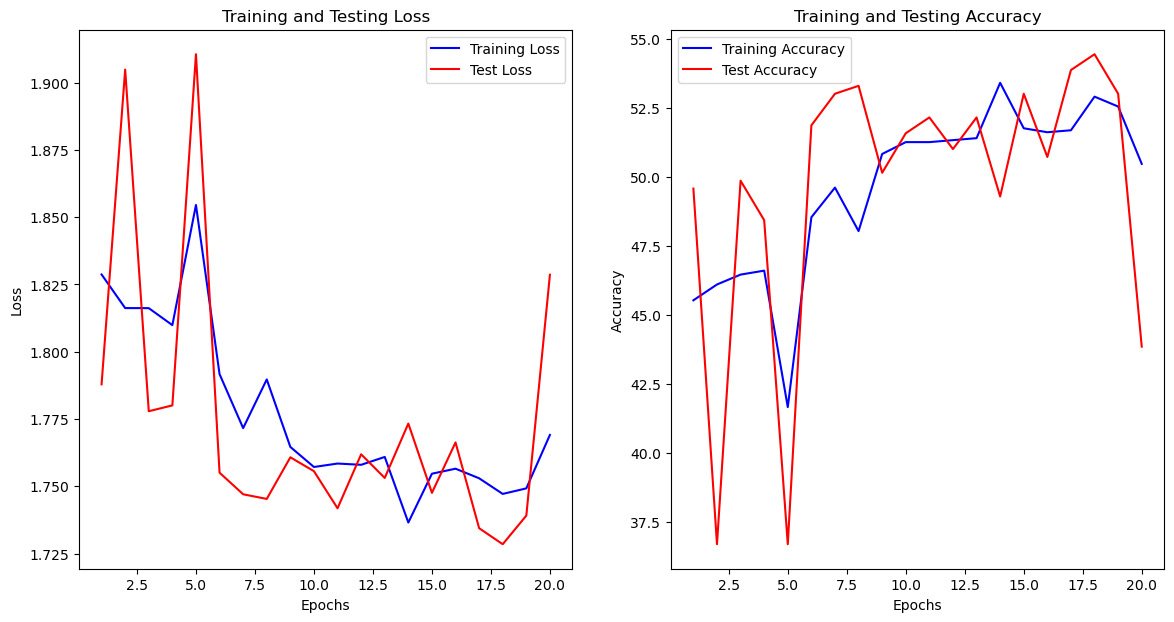

Train Loss: 1.7691, Train Accuracy: 50.47%
Test Loss: 1.8286, Test Accuracy: 43.84%


In [111]:
display_result()

In [1]:
!nvidia-smi

Sun Jul  7 21:05:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.25                 Driver Version: 536.25       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   58C    P8              10W / 215W |    968MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--